# Icentia11k-00-inception.ipynb  
Experiment with using the InceptionTime network for classification of the Icentia11k dataset    
References:  
Icentia11k: https://physionet.org/content/icentia11k-continuous-ecg/1.0/  
Inception Time: https://arxiv.org/pdf/1909.04939  

In [1]:
# Environment setup.
import os
import re
import sys
import platform

import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import fileutils as fu
import model_utils as mu
import icentia11k as ic
import icentia11k_tfrecord as tfr
import inception_model as ict
import model_utils as mu

os_name = platform.system()
print('OS name:            {} {}'.format(os_name, platform.release()))
print('Python version:     {}.{}.{}'.format(sys.version_info[0], sys.version_info[1], sys.version_info[2]))
print('Numpy version:      {}'.format(np.__version__))
print('TensorFlow version: {}'.format(tf.__version__))
print('You are here: {}'.format(os.getcwd()))

OS name:            Windows 10
Python version:     3.10.10
Numpy version:      1.23.2
TensorFlow version: 2.10.0
You are here: D:\dev\jupyter\Icentia11k


In [2]:
# ECG data parameters.
tfr.ECG_LENGTH = 7500
tfr.USE_ZNORM  = True

# Set the local paths based on our environment.
if (os_name == 'Windows'):
    DATA_PATH_ROOT = r'E:/Data/Icentia11k'
else:
    DATA_PATH_ROOT = os.getcwd()

ic.LOCAL_DATA_PATH = os.path.join(DATA_PATH_ROOT, 'data')
ic.LOCAL_TFRECORD_PATH = os.path.join(DATA_PATH_ROOT, 'tfrecord')
print(ic.LOCAL_DATA_PATH)
print(ic.LOCAL_TFRECORD_PATH)

E:/Data/Icentia11k\data
E:/Data/Icentia11k\tfrecord


### Create the datasets

In [3]:
# Get TFRecord file lists.
train_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_train_list.csv')
test_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_test_list.csv')
val_file = os.path.join(ic.LOCAL_TFRECORD_PATH, 'tfrecord_val_list.csv')
train_list, test_list, val_list = tfr.get_tfrecord_lists(
    train_file,
    test_file,
    val_file,
    path=DATA_PATH_ROOT)
train_size = len(train_list)
test_size = len(test_list)
val_size = len(val_list)

print('Train size:      {}'.format(train_size))
print('Test size:       {}'.format(test_size))
print('Validation size: {}'.format(val_size))

Train size:      126000
Test size:       7000
Validation size: 7000


In [4]:
batch_size = 125
buffer_size = train_size // batch_size

train_ds = tf.data.TFRecordDataset(train_list)
train_ds = train_ds.map(tfr.ecg_parse_fn)
train_ds = train_ds.shuffle(buffer_size)
train_ds = train_ds.batch(batch_size, drop_remainder=True)

test_ds = tf.data.TFRecordDataset(test_list)
test_ds = test_ds.map(tfr.ecg_parse_fn)
test_ds = test_ds.batch(batch_size=1, drop_remainder=True)

val_ds = tf.data.TFRecordDataset(val_list)
val_ds = val_ds.map(tfr.ecg_parse_fn)
val_ds = val_ds.batch(batch_size, drop_remainder=True)

### Build or load the model

In [5]:
# Create the input tensor.
ecg_input = tf.keras.Input(shape=(tfr.ECG_LENGTH, 1), name='ecg_input')

In [4]:
# Model parameters.
depth = 5
nconv = 4
model_name = 'InceptionTimeNetV4-D{:02d}'.format(depth)
params = {
    'model_name'  : model_name,
    'classes'     : ic.NUM_CLASSES,
    'depth'       : depth,
    'nconv'       : nconv,
    'nfilt'       : 32,
    'ksize_start' : 8,
    'conv_init'   : 'he_normal',
    'pool_size'   : 8,
    'rate'        : 0.2,
}

# File paths and names.
checkpoint_dir = os.path.join('./checkpoint', model_name)
model_file_base = os.path.join(checkpoint_dir, model_name)
fu.mkpath(checkpoint_dir)
print('Checkpoint directory: {}'.format(checkpoint_dir))

Checkpoint directory: ./checkpoint\InceptionTimeNetV4-D05


In [7]:
build_model = False
if build_model:
    ecg_model = ict.ict_model(ecg_input, **params)
    ecg_model.summary(line_length=120)
else:
    print('Model not built.')

Model not built.


### Load a previous model  
Model formats supported: .h5, .json, TensorFlow SavedModel (provide a directory).

In [10]:
load_previous = True
if load_previous:
    model_file_name = model_file_base + '.h5'
    print(model_file_name)
    ecg_model = mu.load_model(model_file_name)
    ecg_model.summary(line_length=120)
else:
    print('Model not loaded.')

./checkpoint\InceptionTimeNetV4-D05\InceptionTimeNetV4-D05.h5
Model: "InceptionTimeNetV4-D05"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 ecg_input (InputLayer)                [(None, 7500, 1)]          0             []                                      
                                                                                                                        
 Conv1_1 (Conv1D)                      (None, 7500, 32)           288           ['ecg_input[0][0]']                     
                                                                                                                        
 Conv2_1 (Conv1D)                      (None, 7500, 32)           544           ['ecg_input[0][0]']                     
                                                           

 ReLU3_2 (ReLU)                        (None, 3750, 32)           0             ['BN3_2[0][0]']                         
                                                                                                                        
 ReLU4_2 (ReLU)                        (None, 3750, 32)           0             ['BN4_2[0][0]']                         
                                                                                                                        
 MaxPool_2 (MaxPooling1D)              (None, 7500, 160)          0             ['Concat_1[0][0]']                      
                                                                                                                        
 Drop1_2 (Dropout)                     (None, 3750, 32)           0             ['ReLU1_2[0][0]']                       
                                                                                                                        
 Drop2_2 (Dropout)              

 Conv2_4 (Conv1D)                      (None, 938, 32)            81952         ['Pad_4[0][0]']                         
                                                                                                                        
 Conv3_4 (Conv1D)                      (None, 938, 32)            163872        ['Pad_4[0][0]']                         
                                                                                                                        
 Conv4_4 (Conv1D)                      (None, 938, 32)            327712        ['Pad_4[0][0]']                         
                                                                                                                        
 BN1_4 (BatchNormalization)            (None, 938, 32)            128           ['Conv1_4[0][0]']                       
                                                                                                                        
 BN2_4 (BatchNormalization)     

 Drop2_5 (Dropout)                     (None, 469, 32)            0             ['ReLU2_5[0][0]']                       
                                                                                                                        
 Drop3_5 (Dropout)                     (None, 469, 32)            0             ['ReLU3_5[0][0]']                       
                                                                                                                        
 Drop4_5 (Dropout)                     (None, 469, 32)            0             ['ReLU4_5[0][0]']                       
                                                                                                                        
 Conv_skip_5 (Conv1D)                  (None, 469, 32)            5152          ['MaxPool_5[0][0]']                     
                                                                                                                        
 Concat_5 (Concatenate)         

In [ ]:
png_file = os.path.join(checkpoint_dir, '{}.png'.format(model_name))
tf.keras.utils.plot_model(ecg_model, dpi=72, show_shapes=True, to_file=png_file)

### Compile the model 

In [11]:
# Compile the model.
initial_lr = 0.001

opt = tf.keras.optimizers.Adam(
    learning_rate=initial_lr,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1.0e-07,
)

ecg_model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Train the model

In [6]:
# Set up training callbacks.
train_history = None
monitor_label = 'val_accuracy'
monitor_mode  = 'max'
ckpt = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'weights-it03-{epoch:04d}.h5'),
    monitor=monitor_label, 
    mode=monitor_mode,
    save_best_only=True, 
    save_weights_only = True,
    verbose=1, 
)
esc = EarlyStopping(
    monitor=monitor_label,
    mode=monitor_mode,
    min_delta=0, 
    patience=7, 
    restore_best_weights=True,
    verbose=1,
)
rop = ReduceLROnPlateau(
    monitor=monitor_label,
    mode=monitor_mode,
    min_delta=0,
    factor=0.5,
    min_lr=1.0e-08,
    patience=2,
    cooldown=0,
    verbose=1, 
)

In [13]:
# Load pre-existing weights.
load_weights = True
model_weights_file = os.path.join(checkpoint_dir, 'weights-it01-0033.h5')
if load_weights:
    if mu.load_weights(ecg_model, model_weights_file):
        print('Model weights loaded: {}'.format(model_weights_file))
else:
    print('Model weights not loaded.')

Model weights loaded: ./checkpoint\InceptionTimeNetV4-D05\weights-it01-0033.h5


In [14]:
num_epochs = 1
train_model = False
if train_model:
    print('{} Training start.'.format(ic.timestamp()))
    
    train_history = ecg_model.fit(
        x=train_ds, 
        validation_data=val_ds, 
        callbacks=[ckpt, rop, esc],
        epochs=num_epochs)
    
    print('{} Training complete.'.format(ic.timestamp()))
else:
    print('Model not trained.')

Model not trained.


### Save the model

In [15]:
save_model = False
if save_model:
    saved = mu.save_model(ecg_model, model_file_base)
    print('ECG model saved to {}'.format(model_file_base))
else:
    print('ECG model not saved')

ECG model not saved


### Evaluate and run predictions

In [ ]:
# Evaluate the model.
test_loss = ecg_model.evaluate(x=test_ds)
print('loss:     {:0.5f}'.format(test_loss[0]))
print('accuracy: {:0.5f}'.format(test_loss[1]))

In [ ]:
# Create the ground truth targets array.
targets_list = []
for tds in test_ds:
    targets_list.append(tds[1])
targets = np.squeeze(np.asarray(targets_list), 1) # Convert dataset to array, remove unused dimension
print('Targets shape: {}'.format(targets.shape))

In [ ]:
# Perform predictions on the test dataset.
predictions = np.asarray(
    ecg_model.predict(
        x=test_ds,
        steps=None,
        verbose=1
    )
)
print('Predictions shape: {}'.format(predictions.shape))

In [ ]:
# Create a classification array.
classifications = np.zeros(predictions.shape)
idx_array = np.argmax(predictions, axis=1)
for i in range(predictions.shape[0]):
    p = predictions[i]
    idx = idx_array[i]
    if (p[idx] > 0.5):
        classifications[i,idx] = 1

In [ ]:
# Sanity check the first element.
print('Prediction:     {}'.format(predictions[0]))
print('Target:         {}'.format(targets[0]))
print('Classification: {}'.format(classifications[0]))

### Save the results

In [ ]:
# Function to append current history to previous history
def append_history(h_current, h_new):
    for k in h_new:
        if k in h_current:
            h_current[k] += d 
        else:
            h_current[k] = h_new[k]
    return h_current

In [7]:
# Save the results.
save_results = False
pickle_file = model_file_base + '_results.pickle'

# Append training history.
total_history = None

if train_history is not None:
    if os.path.isfile(pickle_file):
        saved_results = mu.load_results(pickle_file)
        total_history = append_history(saved_results['history'], train_history.history)
    else:
        total_history = train_history.history  
    
if save_results:
    pickle_results = {
        'params' : params,
        'max_epochs' : num_epochs,
        'class_names' : ic.CLASS_NAMES,
        'targets' : targets,
        'predictions' : predictions,
        'classifications' : classifications,
        'history' : total_history
    }
    print(mu.save_results(pickle_results, pickle_file))
    print('Results saved to {}.'.format(pickle_file))
else:
    print('Results not saved.')

Results not saved.


### Load previously saved results

In [8]:
load_previous = True
if load_previous:
    saved_results = mu.load_results(pickle_file)
    num_epochs = saved_results['max_epochs']
    targets = saved_results['targets']
    predictions = saved_results['predictions']
    classifications = saved_results['classifications']
    total_history = saved_results['history']
    print('Previous results loaded.')
else:
    print('Previous results not loaded.')

Previous results loaded.


### Compute metrics

In [18]:
# Run a classification report.
report = classification_report(targets, classifications, target_names=ic.CLASS_NAMES, zero_division=0)
print(report)

              precision    recall  f1-score   support

           Q       0.96      0.97      0.97      1750
           N       0.97      0.96      0.97      1750
         AFL       0.97      0.94      0.95      1750
        AFIB       0.95      0.96      0.95      1750

   micro avg       0.96      0.96      0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000
 samples avg       0.96      0.96      0.96      7000



In [29]:
# Additional metrics for each class.
for i in range(ic.NUM_CLASSES):
    cm = confusion_matrix(targets[:,i], classifications[:,i])
    acc = (cm[0,0] + cm[1,1]) / np.sum(cm)
    ppv = cm[1,1] / (cm[1,1] + cm[0,1])
    fpr, tpr, _ = roc_curve(targets[:,i], classifications[:,i])
    roc_auc = auc(fpr, tpr)
    print('Confusion matrix for class {}:'.format(ic.CLASS_NAMES[i]))
    print(cm)
    print('ACC: {:0.4f}'.format(acc))
    print('PPV: {:0.4f}'.format(ppv))
    print('AUC: {:0.4f}'.format(roc_auc))
    print()

no_class_counts = np.zeros(ic.NUM_CLASSES)
num_examples = targets.shape[0]
for i in range(num_examples):
    if np.sum(classifications[i]) == 0:
        no_class_counts[np.argmax(targets[i])] += 1
no_class_sum = np.sum(no_class_counts)
no_class_pct = 100. * no_class_sum / num_examples
print('There are {} predictions with no classification ({:0.2f}%).'.format(int(no_class_sum), no_class_pct))
for i in range(ic.NUM_CLASSES):
    print('True {:5s}: {}'.format(ic.CLASS_NAMES[i], int(no_class_counts[i])))

Confusion matrix for class Q:
[[5176   74]
 [  47 1703]]
ACC: 0.9827
PPV: 0.9584
AUC: 0.9795

Confusion matrix for class N:
[[5190   60]
 [  62 1688]]
ACC: 0.9826
PPV: 0.9657
AUC: 0.9766

Confusion matrix for class AFL:
[[5197   53]
 [ 103 1647]]
ACC: 0.9777
PPV: 0.9688
AUC: 0.9655

Confusion matrix for class AFIB:
[[5158   92]
 [  77 1673]]
ACC: 0.9759
PPV: 0.9479
AUC: 0.9692

There are 10 predictions with no classification (0.14%).
True Q    : 0
True N    : 0
True AFL  : 4
True AFIB : 6


### Plot training metrics  

Total epochs: 40
Max val_accuracy at epoch 33: 0.9554
Train accuracy at epoch 33:   0.9838
Difference: -2.89%


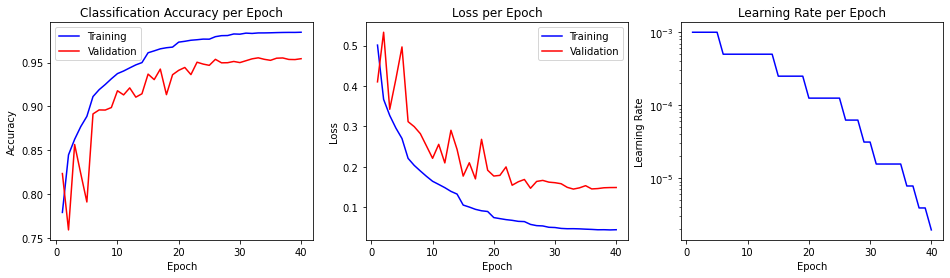

In [12]:
fig, (ax_acc, ax_mse, ax_lr) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
plt.yscale('linear')

total_epochs = len(total_history['loss'])
max_idx = np.argmax(total_history['val_accuracy'])
max_acc = total_history['val_accuracy'][max_idx]
train_acc = total_history['accuracy'][max_idx]
diff = 100. * (max_acc-train_acc)/train_acc
print('Total epochs: {}'.format(total_epochs))
print('Max val_accuracy at epoch {}: {:0.4f}'.format(max_idx+1, max_acc))
print('Train accuracy at epoch {}:   {:0.4f}'.format(max_idx+1, train_acc))
print('Difference: {:0.2f}%'.format(diff))

ax_acc.plot(range(1, total_epochs+1), total_history['accuracy'], color='blue', label='Training')
ax_acc.plot(range(1, total_epochs+1), total_history['val_accuracy'], color='red', label='Validation')
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Accuracy')
ax_acc.set_title('Classification Accuracy per Epoch')
ax_acc.legend()

ax_mse.plot(range(1, total_epochs+1), total_history['loss'], color='blue', label='Training')
ax_mse.plot(range(1, total_epochs+1), total_history['val_loss'], color='red', label='Validation')
ax_mse.set_xlabel('Epoch')
ax_mse.set_ylabel('Loss')
ax_mse.set_title('Loss per Epoch')
ax_mse.legend()

plt.yscale('log')
ax_lr.plot(range(1, total_epochs+1), total_history['lr'], color='blue')
ax_lr.set_xlabel('Epoch')
ax_lr.set_ylabel('Learning Rate')
ax_lr.set_title('Learning Rate per Epoch')

plt.show()

### Plot a confusion matrix

In [31]:
class my_formatter(matplotlib.ticker.Formatter):
    def __init__(self, x, pos):
        super(matplotlib.ticker.Formatter, self).__init__()
    def __call__(self, x, pos):
        return '{:0.2f}'.format(10.**x)

In [32]:
def plot_confusion_matrix(targets, classifications, class_names):
    num_examples = targets.shape[0]
    num_classes = targets.shape[1]
    
    # Count plot_confusion_matrixactual vs. classification instances.
    heatmap_data = np.zeros((num_classes, num_classes))
    for i in range(num_examples):
        x = np.argmax(classifications[i])
        y = np.argmax(targets[i])
        heatmap_data[x, (num_classes - y - 1)] += 1
    #print(heatmap_data)
    heatmap_pct = (heatmap_data * 100) / num_examples  # Convert to percent of total
    #print(heatmap_pct)
    heatmap_data = np.log10(heatmap_pct)  # Convert to log scale for plotting
    #print(heatmap_data)
    
    # Create the color plot.
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(heatmap_data.T, cmap='Blues') 
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(num_classes)+0.5, labels=class_names,)
    ax.set_yticks(np.arange(num_classes)+0.5, labels=reversed(class_names))

    # Overlay values.
    for i in range(ic.NUM_CLASSES):
        for j in range(ic.NUM_CLASSES):
            val = '{:0.2f}'.format(heatmap_pct[i, j])
            text = ax.text(i+0.5, j+0.5, val, ha='center', va='center')

    # Create a colorbar.
    tickpos = [0.05, 0.1, 0.3, 1, 3, 10, 20]
    ticklist = np.log10(tickpos)
    plt.colorbar(heatmap, label='classification %', format=my_formatter(x, pos=None), ticks=ticklist)
    plt.show()

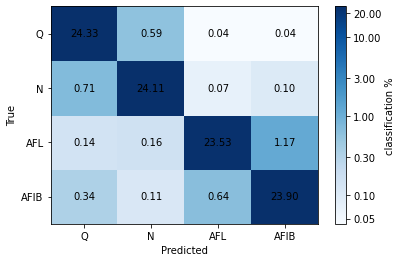

In [33]:
plot_confusion_matrix(targets, classifications, ic.CLASS_NAMES)